In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  75.7M      0  0:00:10  0:00:10 --:--:-- 42.0M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = b"JFIF" in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


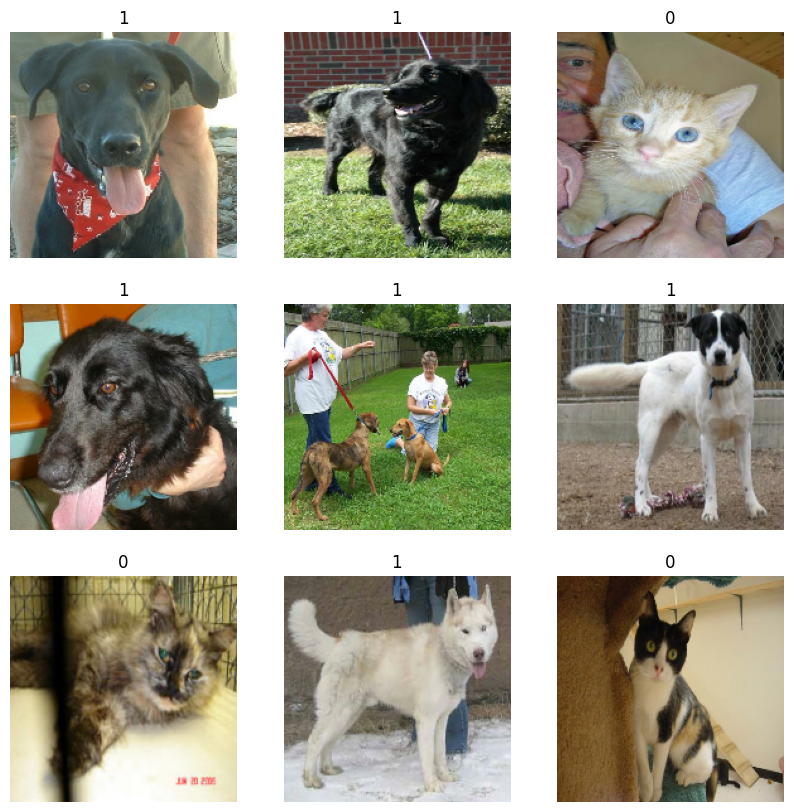

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [8]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images


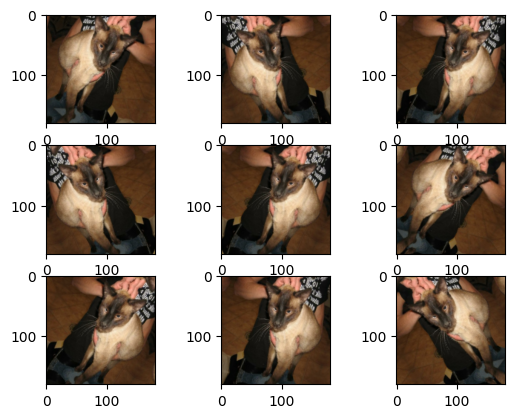

In [9]:
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y),
  num_parallel_calls=tf_data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [11]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x
  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
    x = layers.add([x, residual])
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)


In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5744 - loss: 0.7791

147/147 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5745 - loss: 0.7786 - val_accuracy: 0.4957 - val_loss: 0.7244
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6423 - loss: 0.6291

147/147 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6425 - loss: 0.6290 - val_accuracy: 0.5073 - val_loss: 0.7141
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7011 - loss: 0.5772

147/147 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7011 - loss: 0.5772 - val_accuracy: 0.5335 - val_loss: 0.7713
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7196 - loss: 0.5511

147/147 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.7197 - loss: 0.5510 - val_accuracy: 0.6557 - val_loss: 0.7074
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7690 - loss: 0.4850

147/147 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.7690 - loss: 0.4849 - val_accuracy: 0.5916 - val_loss: 0.8494
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8010 - loss: 0.4358

147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8010 - loss: 0.4357 - val_accuracy: 0.7204 - val_loss: 0.8357
Epoch 7/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 41:59 17s/step - accuracy: 0.8359 - loss: 0.3384

KeyboardInterrupt: 